In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# mnist dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from dataset_tools import OwnDataset
from plotting import show_img, loss_plots, plot_random_images, plot_image_comparison, plot_latent
from collections import defaultdict


cuda = torch.cuda.is_available()
print(cuda)

True


# Data

In [2]:
tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.view(-1)) # notice that we dont flatten when we are going to use CNN
])

data_train = OwnDataset(train=True, transform=tf)
data_test = OwnDataset(train=False, transform=tf)

train_loader = DataLoader(data_train, batch_size=64, shuffle=True, pin_memory=cuda)
test_loader = DataLoader(data_test, batch_size=64, shuffle=True, pin_memory=cuda)



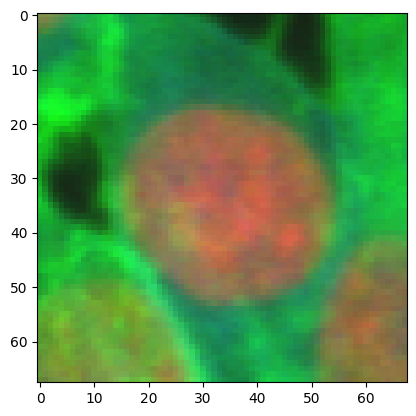

In [3]:
# get a sample image from the dataset
sample = data_train[612][0]

# show the image
show_img(sample.view(3,68,68))


In [4]:
# test how a sample looks
x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([64, 3, 68, 68]) torch.Size([64])


# VAE

In [5]:
from models import VAE_CELL_CNN
from loss_functions import loss_function

model = VAE_CELL_CNN(input_dim=(3,68,68), hidden_dim=512, latent_dim=2)
print(model)

if cuda:
    model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-3)


VAE_CELL_CNN(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=20736, out_features=512, bias=True)
    (10): Sigmoid()
  )
  (mu): Linear(in_features=512, out_features=2, bias=True)
  (sigma): Linear(in_features=512, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=20736, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Unflatten(

In [6]:
# test forward pass
x, y = next(iter(train_loader))
print(f"x.shape: {x.shape}")

if cuda:
    x = x.cuda()

output = model(x)
x_hat = output["x_hat"]
print(f"x_hat.shape: {x_hat.shape}")

assert x_hat.shape == x.shape

x.shape: torch.Size([64, 3, 68, 68])


x_hat.shape: torch.Size([64, 3, 68, 68])


## Training

In [7]:
num_epochs = 10

train_loss = []
train_mse_loss = []
train_kld_loss = []
valid_loss = []

for epoch in range(num_epochs):
    batch_loss = []
    mse_batch_loss = []
    kld_batch_loss = []
    model.train()

    for x, y in train_loader:
        if cuda:
            x = x.cuda()

        optimizer.zero_grad()
        output = model(x)
        x_hat, mu, sigma = output["x_hat"], output["mu"], output["sigma"]
        loss_fn = loss_function(x, x_hat, mu, sigma)
        mse_loss = loss_fn["MSE"]
        kld_loss = loss_fn["KLD"]
        loss = loss_fn["loss"]

        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        mse_batch_loss.append(mse_loss.item())
        kld_batch_loss.append(kld_loss.item())
        

    train_loss.append(np.mean(batch_loss))
    train_mse_loss.append(np.mean(mse_batch_loss))
    train_kld_loss.append(np.mean(kld_batch_loss))

    # print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}")
    print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}, mse: {train_mse_loss[-1]}, kld: {train_kld_loss[-1]}")




Epoch 1/10, loss: 23163.875024912308, mse: 22969.34498565051, kld: 194.53003328673694
Epoch 2/10, loss: 13638.811894630899, mse: 13468.45358587771, kld: 170.35832397305236
Epoch 3/10, loss: 14679.062878667091, mse: 14389.494808274872, kld: 289.56801986694336
Epoch 4/10, loss: 12737.685006277901, mse: 12509.622543646365, kld: 228.0624553913973
Epoch 5/10, loss: 12149.848490812341, mse: 11876.178695990115, kld: 273.66981545273137
Epoch 6/10, loss: 12182.387117346938, mse: 11905.181819993622, kld: 277.20525659833635
Epoch 7/10, loss: 11650.074330855388, mse: 11373.92282415896, kld: 276.15151603854434
Epoch 8/10, loss: 12090.251566984216, mse: 11829.968142139669, kld: 260.283440648293
Epoch 9/10, loss: 12918.873183892698, mse: 12551.959303252552, kld: 366.9138779932139
Epoch 10/10, loss: 12390.654590840242, mse: 12163.274760343591, kld: 227.37983563481544


## Plots

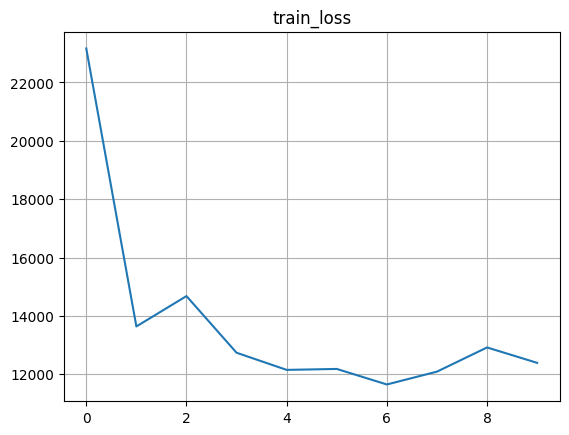

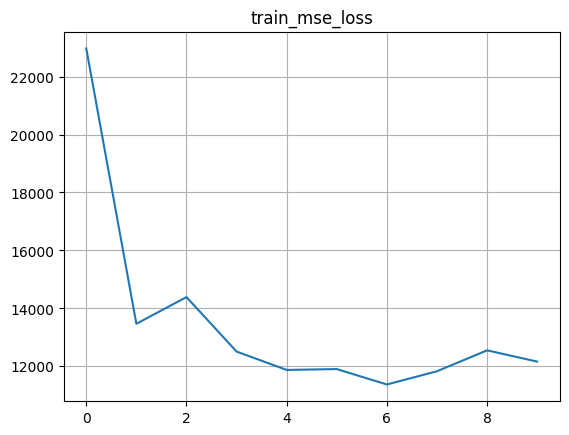

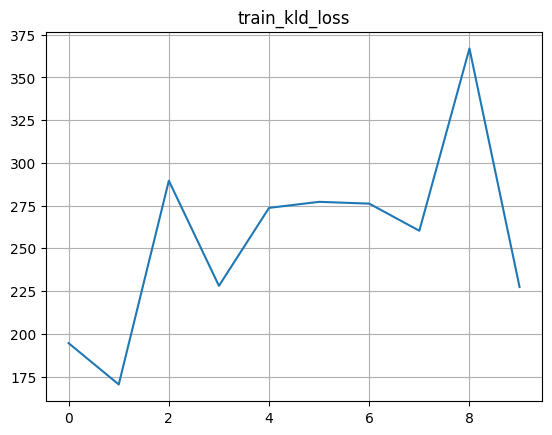

In [8]:
# make a dictionary with the losses as keys and the values as lists
loss_data = {}
loss_data["train_loss"] = train_loss
loss_data["train_mse_loss"] = train_mse_loss
loss_data["train_kld_loss"] = train_kld_loss


loss_plots(loss_data, invidual_plots=True)

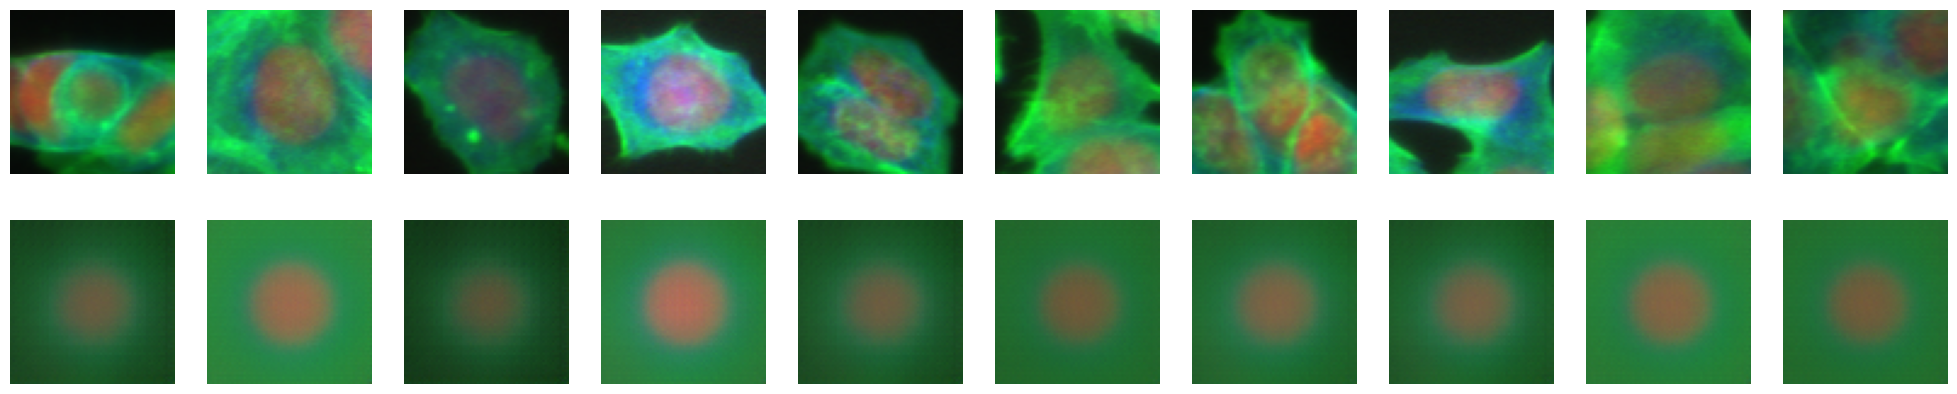

In [9]:
# test the model
plot_image_comparison(model, test_loader, cuda, img_shape=(3,68,68))


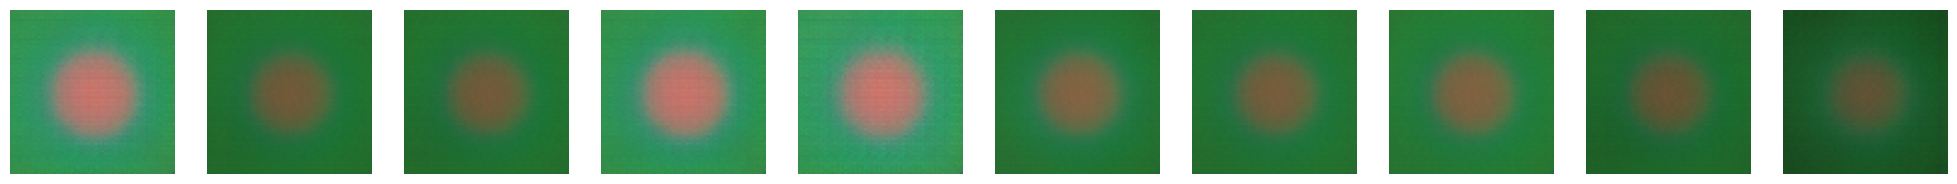

In [10]:
# plot random images generated from the model
plot_random_images(model, n=10, img_shape=(3,68,68), cuda=cuda)

In [11]:
from inference import Inference

inference = Inference(model, test_loader)

In [12]:
samples = inference.samples